# Toronto Dwellings Analysis Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions to create a Panel dashboard.

In [1]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from pathlib import Path
from dotenv import load_dotenv


Bad key "text.kerning_factor" on line 4 in
C:\Users\richa\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [ ]:
# Initialize the Panel Extensions (for Plotly)
import panel as pn
pn.extension("plotly")

In [ ]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [4]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/toronto_neighbourhoods_census_data.csv")
to_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/toronto_neighbourhoods_coordinates.csv")
df_neighbourhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

### Global available data

In [5]:
# Getting the data from the top 10 expensive neighbourhoods
top_10_expensive_neighbourhoods_new_df = to_data.groupby(['neighbourhood'])[['average_house_value']].mean().reset_index()
top_10_expensive_neighbourhoods = top_10_expensive_neighbourhoods_new_df.sort_values('average_house_value', ascending=False).set_index("neighbourhood").head(10)

# Calculate the mean number of dwelling types units per year
number_of_dwelling_types_units_per_year = to_data.groupby('year').sum()
number_of_dwelling_types_units_per_year.drop(['average_house_value','shelter_costs_owned','shelter_costs_rented'], axis=1, inplace=True)

# Calculate the average monthly shelter costs for owned and rented dwellings
average_monthly_shelter_costs = to_data.groupby('year')[['shelter_costs_owned','shelter_costs_rented']].mean()

# Create a new DataFrame with the mean house values by neighbourhood per year
mean_house_values_by_neighbourhood_per_year = to_data.groupby(['year','neighbourhood'])[['average_house_value']].mean().reset_index()

# Calculate the average house value per Year
average_house_value_per_Year = to_data.groupby('year')[['average_house_value']].mean()

### Panel Visualization Functions

In [9]:
# Define Panel visualization functions
def neighbourhood_map():
    """Neighbourhood Map"""
   
    # Calculate the mean values for each neighborhood
    mean_values_for_each_neighborhood = to_data.groupby('neighbourhood').mean().reset_index()
    # Join the average values with the neighbourhood locations
    combine_df = pd.merge(df_neighbourhood_locations,mean_values_for_each_neighborhood,on='neighbourhood')

    # Plot Data
    map = px.scatter_mapbox(
        combine_df,
        lat="lat",
        lon="lon",
        hover_data = ['shelter_costs_owned', 
                      'shelter_costs_rented', 
                      'single_detached_house', 
                      'apartment_five_storeys_plus', 
                      'movable_dwelling', 
                      'semi_detached_house', 
                      'row_house', 
                      'duplex', 
                      'apartment_five_storeys_less', 
                      'other_house'],
        size="average_house_value",
        color="average_house_value",
        zoom=9,
        color_continuous_scale=px.colors.cyclical.IceFire
    )
    
    return map
    
def create_bar_chart(data, title, xlabel, ylabel, color):
    """
    Create a barplot based in the data argument.
    """
    
    fig = plt.figure()
    data.plot(kind='bar', color = color, rot = 90)
    plt.title(title, fontdict = {'fontsize' : 14, 'fontweight' : 'bold'})
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    return pn.pane.Matplotlib(fig)
    
def create_line_chart(data, title, xlabel, ylabel, color):
    """
    Create a line chart based in the data argument.
    """
    
    fig = plt.figure()
    data.plot(color = color)
    plt.title(title,fontdict = {'fontsize' : 14, 'fontweight' : 'bold'})
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    return pn.pane.Matplotlib(fig)

def average_house_value():
    """Average house values per year."""
    
    average_house_value_per_Year = to_data.groupby('year')[['average_house_value']].mean()
    
    return average_house_value_per_Year

def average_house_value_plot():
    
    fig = plt.figure()
    average_house_value_per_Year.plot()
    plt.title("Average House Value in Toronto",fontdict = {'fontsize' : 14, 'fontweight' : 'bold'})
    plt.xlabel('Year')
    plt.ylabel('Average House Value')
    plt.show()
    
    return pn.pane.Matplotlib(fig)

def average_value_by_neighbourhood():
    """Average house values by neighbourhood."""
    
    mean_house_values_by_neighbourhood_per_year = to_data.groupby(['year','neighbourhood'])[['average_house_value']].mean().reset_index()
    
    return mean_house_values_by_neighbourhood_per_year.hvplot(label = "Average house value per neighbourhood",
                                                  x = 'year',
                                                  y = 'average_house_value',
                                                  xlabel='Year',
                                                  ylabel='Avg. House Value',
                                                  groupby='neighbourhood')

def number_dwelling_types():
    """Number of dwelling types per year"""
    
    number_of_dwelling_types_units_per_year = to_data.groupby(['year','neighbourhood']).sum().reset_index()
    number_of_dwelling_types_units_per_year_newdf = to_data.groupby(['year','neighbourhood']).sum().reset_index()
    number_of_dwelling_types_units_per_year_newdf.drop(['average_house_value',
                                                        'shelter_costs_owned',
                                                        'shelter_costs_rented'], 
                                                         axis=1, inplace=True)
    
    return number_of_dwelling_types_units_per_year_newdf.set_index('year').hvplot(kind ="bar",
                                                                 xlabel='Year',
                                                                 ylabel='Dwelling Type Units',
                                                                 groupby='neighbourhood',
                                                                 height = 500).opts(xrotation=90)
    

def average_house_value_snapshot():
    """Average house value for all Toronto's neighbourhoods per year."""

    average_house_value_toronto_neighbourhoods_per_year = to_data.groupby(['neighbourhood']).mean()
    
    return average_house_value_toronto_neighbourhoods_per_year

def top_most_expensive_neighbourhoods():
    """Top 10 most expensive neighbourhoods."""
    
    top_10_expensive_neighbourhoods_new_df = to_data.groupby(['neighbourhood']).mean().reset_index()
    top_10_expensive_neighbourhoods = top_10_expensive_neighbourhoods_new_df.sort_values('average_house_value', ascending=False).set_index("neighbourhood").reset_index().head(10)
    
    return top_10_expensive_neighbourhoods

def top_most_expensive_neighbourhoods_plot():
    
    """Plot the average house value per year as a line chart"""
    
    fig = plt.figure()
    average_house_value_per_Year['average_house_value'].plot()
    plt.title("Average House Value in Toronto",fontdict = {'fontsize' : 14, 'fontweight' : 'bold'})
    plt.xlabel('Year')
    plt.ylabel('Average House Value')
    return pn.pane.Matplotlib(fig)

def sunburts_cost_analysis():
    """Sunburst chart to conduct a costs analysis of most expensive neighbourhoods in Toronto per year."""
    
    # Fetch the data from all expensive neighbourhoods per year.
    all_expensive_neighbourhoods_per_year = to_data.groupby(['year','neighbourhood']).sum().reset_index()
    top_10_expensive_neighbourhoods_df = all_expensive_neighbourhoods_per_year.sort_values('average_house_value', ascending=False).head(10)
    
    # Fetch the data from all expensive neighbourhoods per year.
    all_expensive_neighbourhoods_per_year_2001 = all_expensive_neighbourhoods_per_year.loc[all_expensive_neighbourhoods_per_year['year'] == 2001]
    all_expensive_neighbourhoods_per_year_2006 = all_expensive_neighbourhoods_per_year.loc[all_expensive_neighbourhoods_per_year['year'] == 2006]
    all_expensive_neighbourhoods_per_year_2011 = all_expensive_neighbourhoods_per_year.loc[all_expensive_neighbourhoods_per_year['year'] == 2011]
    all_expensive_neighbourhoods_per_year_2016 = all_expensive_neighbourhoods_per_year.loc[all_expensive_neighbourhoods_per_year['year'] == 2016]

    # Store top 10 expensive neighrhoods for each year
    top_10_expensive_neighbourhoods_df_2001 = all_expensive_neighbourhoods_per_year_2001.sort_values('average_house_value', ascending=False).head(10)
    top_10_expensive_neighbourhoods_df_2006 = all_expensive_neighbourhoods_per_year_2006.sort_values('average_house_value', ascending=False).head(10)
    top_10_expensive_neighbourhoods_df_2011 = all_expensive_neighbourhoods_per_year_2011.sort_values('average_house_value', ascending=False).head(10)
    top_10_expensive_neighbourhoods_df_2016 = all_expensive_neighbourhoods_per_year_2016.sort_values('average_house_value', ascending=False).head(10)

    top_10_expensive_neighbourhoods_df_combined_year = pd.concat([top_10_expensive_neighbourhoods_df_2001,
                                                                top_10_expensive_neighbourhoods_df_2006,
                                                                top_10_expensive_neighbourhoods_df_2011,
                                                                top_10_expensive_neighbourhoods_df_2016])
    top_10_expensive_neighbourhoods_df_combined_year['shelter_costs_ownedadditional_column_for_hover'] = top_10_expensive_neighbourhoods_df_combined_year['shelter_costs_owned']

    # Create new df for "shelter_costs_ownedadditional_column_for_hover"
    top_10_expensive_neighbourhoods_df['shelter_costs_ownedadditional_column_for_hover'] = top_10_expensive_neighbourhoods_df['shelter_costs_owned']

    # Create the sunburst chart
    fig =px.sunburst(
    top_10_expensive_neighbourhoods_df_combined_year,
    path=['year', 'neighbourhood'],
    hover_data = ['shelter_costs_owned', 'shelter_costs_rented'],
    values='average_house_value',
    color = 'shelter_costs_ownedadditional_column_for_hover',
    color_continuous_scale='Blues',
    title = "Costs Analysis of Most Expensive Neighbourhoods in Toronto per Year"
    )
    
    return fig

# Average House Values in Toronto per Neighbourhood
fig = px.bar(mean_house_values_by_neighbourhood_per_year, 
             x="neighbourhood", 
             y="average_house_value", 
             color="average_house_value", 
             facet_row="year",
             title = "Average House Values in Toronto per neighbourhood",
             height=1000,
             width=1000)


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

Real Estate Analysis of Toronto from 2001 to 2016


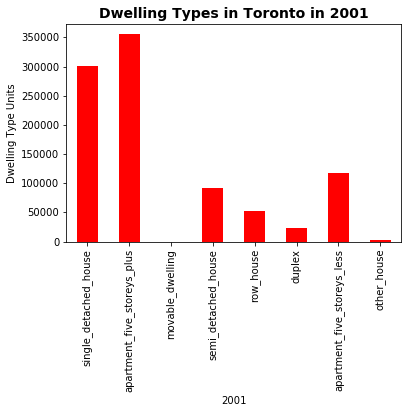

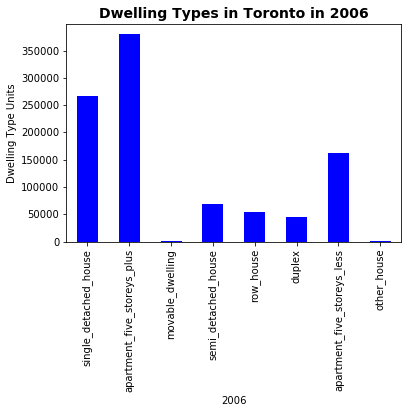

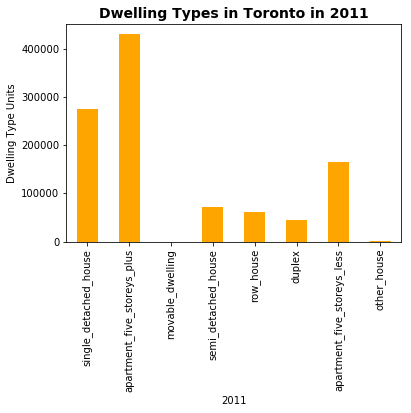

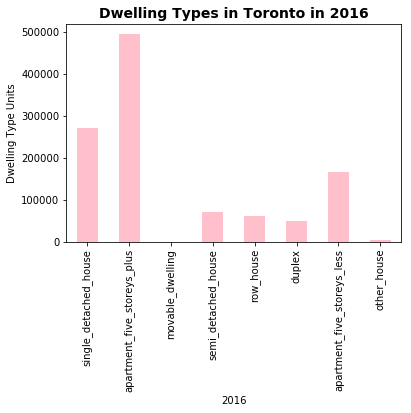

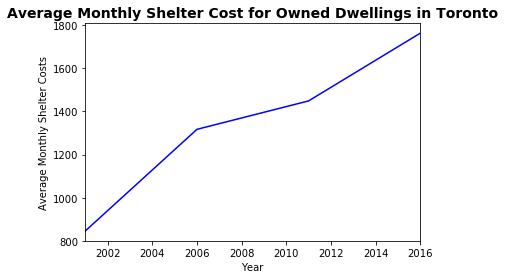

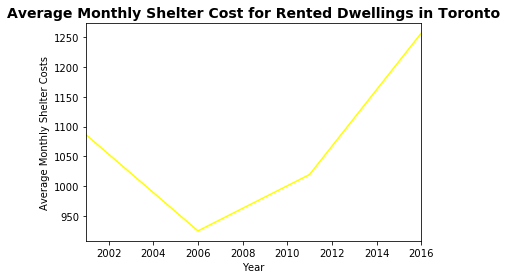

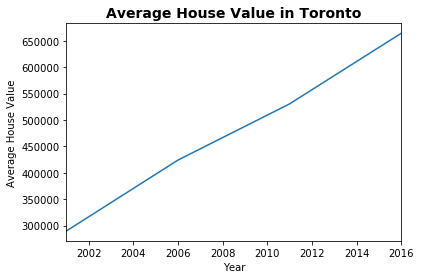

In [10]:
print ('Real Estate Analysis of Toronto from 2001 to 2016')

# Create a Title for the Dashboard
title = pn.Column('# Real Estate Analysis of Toronto from 2001 to 2016')

# Define a welcome text

welcome_text = pn.pane.Markdown("# Average House value in Toronto")

# Create a tab layout for the dashboard
# Create tabs

neighbourhood_map = pn.Column(welcome_text, neighbourhood_map())

Yearly_Market_Analysis_2001_2006 = pn.Row(create_bar_chart(number_of_dwelling_types_units_per_year.iloc[0],
                 "Dwelling Types in Toronto in 2001",
                 "2001",
                 'Dwelling Type Units',
                 'red'), create_bar_chart(number_of_dwelling_types_units_per_year.iloc[1],
                 "Dwelling Types in Toronto in 2006",
                 "2006",
                 'Dwelling Type Units',
                 'blue'))

Yearly_Market_Analysis_2011_2016 = pn.Row(create_bar_chart(number_of_dwelling_types_units_per_year.iloc[2],
                 "Dwelling Types in Toronto in 2011",
                 "2011",
                 'Dwelling Type Units',
                 'orange'), create_bar_chart(number_of_dwelling_types_units_per_year.iloc[3],
                 "Dwelling Types in Toronto in 2016",
                 "2016",
                 'Dwelling Type Units',
                 'pink'))

Yearly_Market_Analysis = pn.Column(Yearly_Market_Analysis_2001_2006, Yearly_Market_Analysis_2011_2016)

Shelter_Costs_Vs_House_Value = pn.Column(create_line_chart(average_monthly_shelter_costs['shelter_costs_owned'],
                 "Average Monthly Shelter Cost for Owned Dwellings in Toronto",
                 "Year",
                 'Average Monthly Shelter Costs',
                 'blue'), create_line_chart(average_monthly_shelter_costs['shelter_costs_rented'],
                 "Average Monthly Shelter Cost for Rented Dwellings in Toronto",
                 "Year",
                 'Average Monthly Shelter Costs',
                 'yellow'), top_most_expensive_neighbourhoods_plot())

combine_neighbourhood_dwelling = pn.Column(average_value_by_neighbourhood(), number_dwelling_types())
Neighbourhood_Analysis = pn.Row(combine_neighbourhood_dwelling, fig)

Top_Expensive_Neighbourhoods = pn.Row(top_10_expensive_neighbourhoods.hvplot(kind ="bar",
                                       label = "Top 10 Expensive Neighbourhoods in Toronto",
                                       xlabel='Neibourhood',
                                       ylabel='Avg. House Value',
                                       height = 500).opts(xrotation=90), sunburts_cost_analysis())

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
    [1] Column
        [0] Row
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
        [1] Row
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
    [2] Column
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
    [3] Row
        [0] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                    [1] VSpacer()
            [1] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                    [1] VSpacer()
        [1] Plotly(Figure)
    [4] Row
        [0] HoloViews(Bars)
        [1] Plotly(Figure)
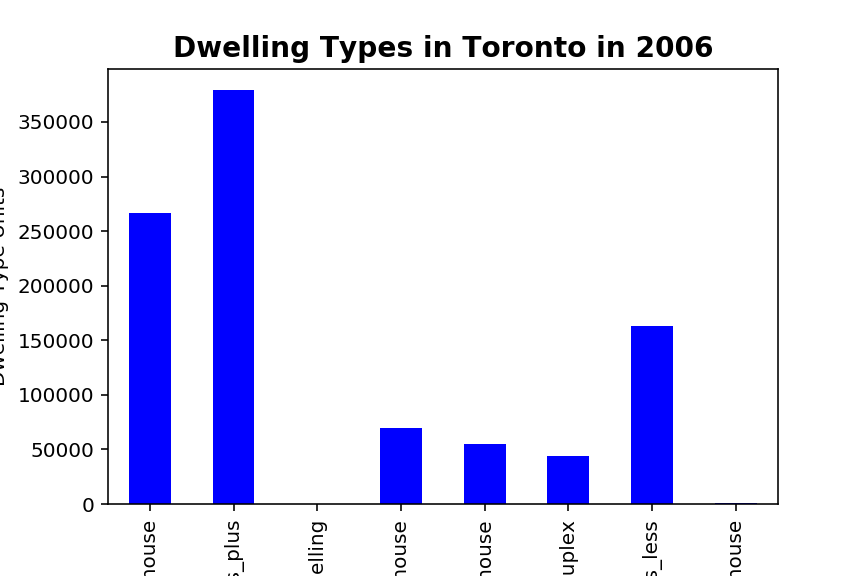
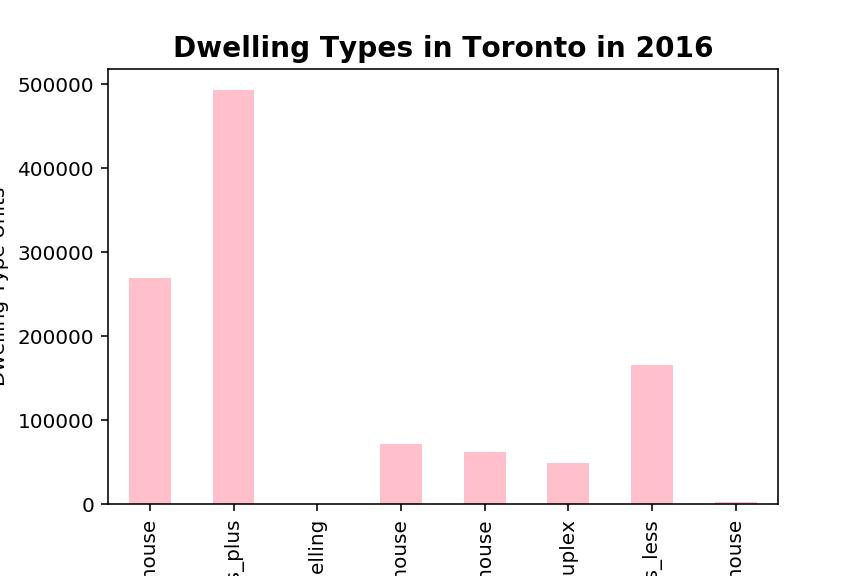
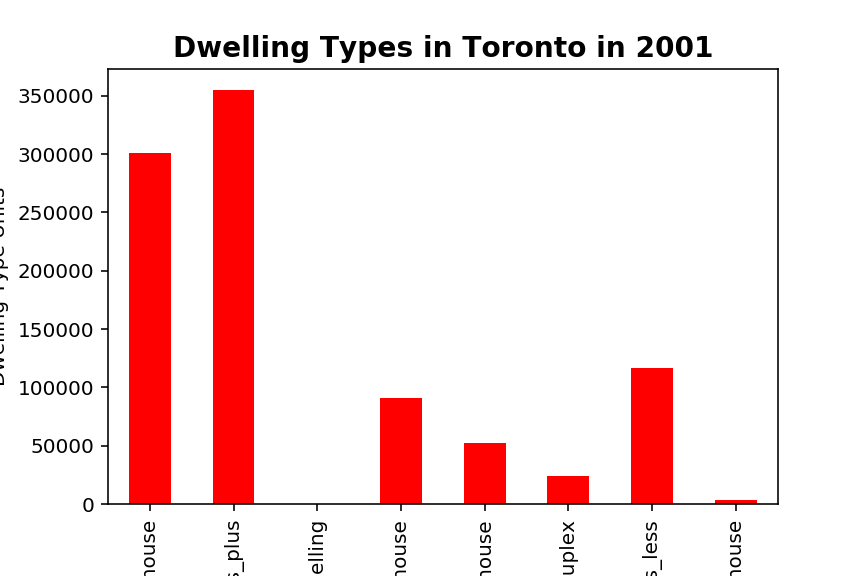
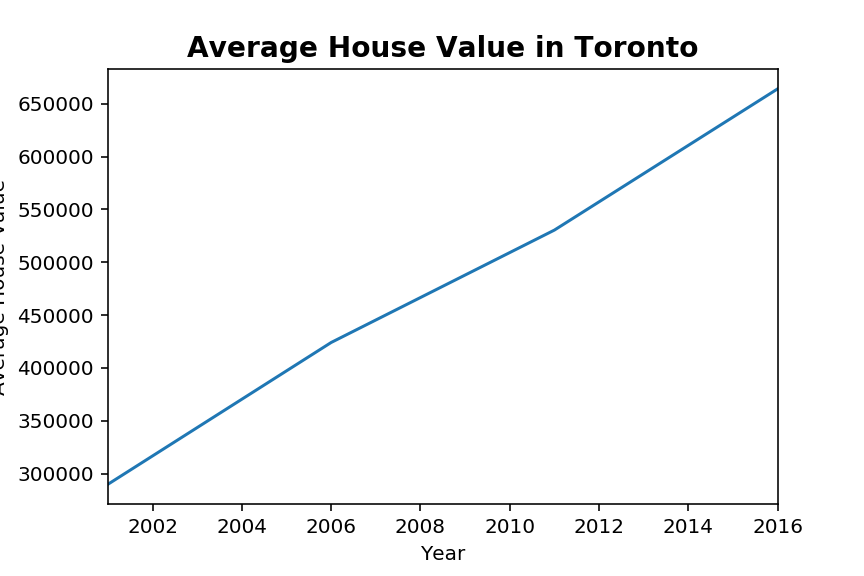
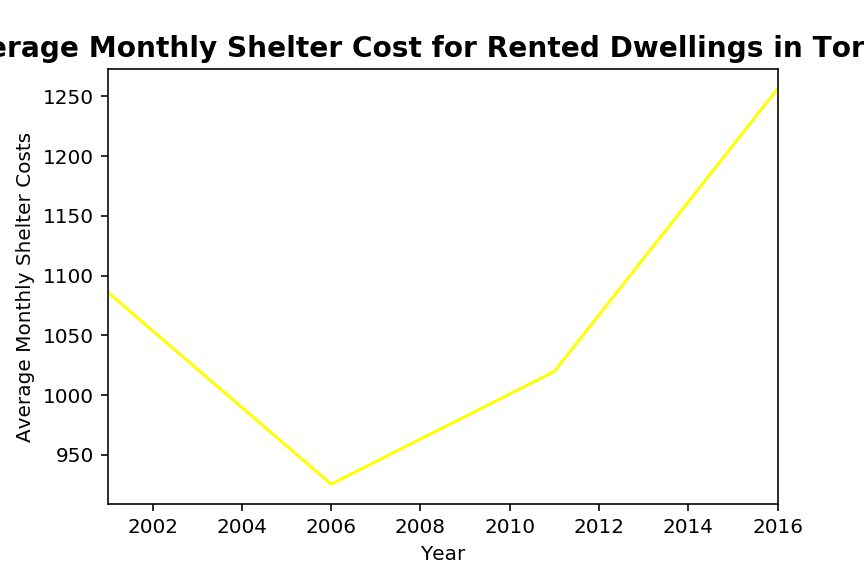
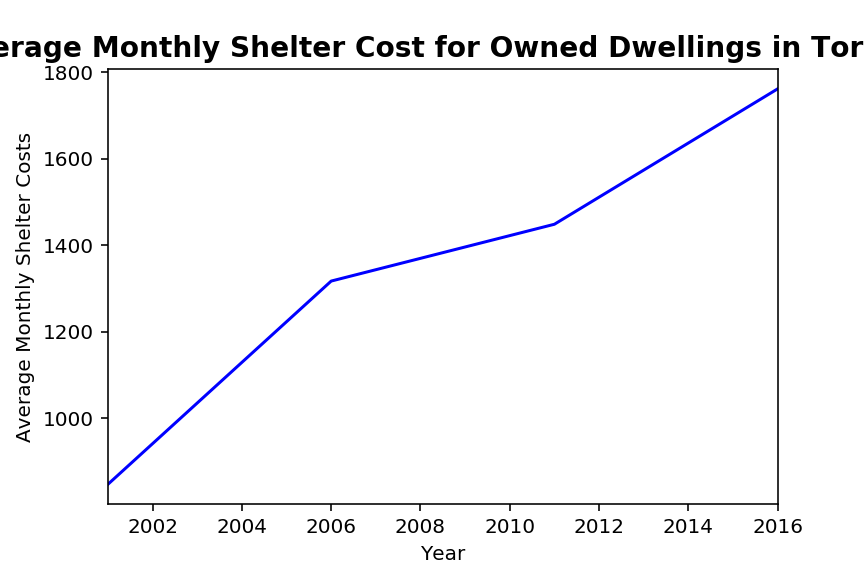
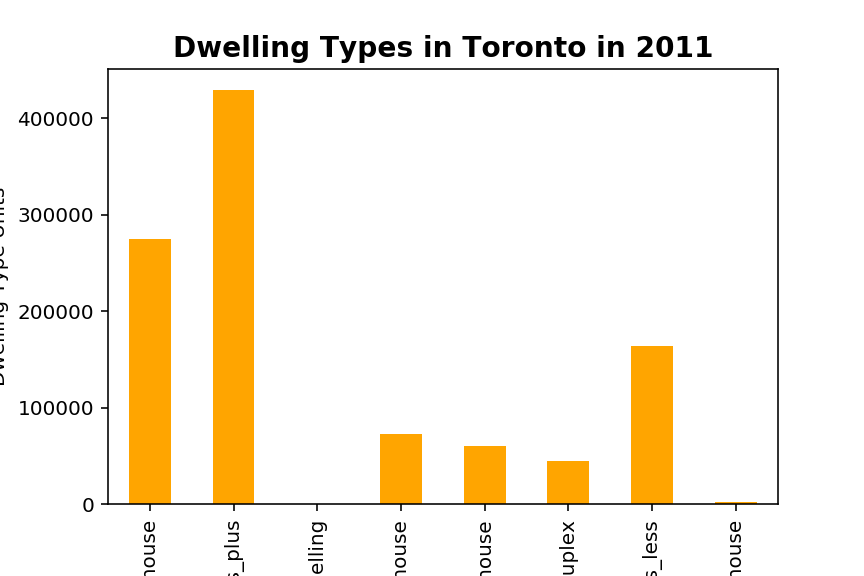

In [11]:
welcome_text
# Create the main dashboard
dashboard = pn.Tabs(
     ("Welcome", neighbourhood_map),
     ("Yearly Market Analysis", Yearly_Market_Analysis),
     ("Shelter Costs Vs. House Value", Shelter_Costs_Vs_House_Value),
     ("Neighbourhood Analysis", Neighbourhood_Analysis),
     ("Top Expensive Neighbourhoods", Top_Expensive_Neighbourhoods)
)
dashboard

## Serve the Panel Dashboard

Tabs(active=2)
    [0] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
    [1] Column
        [0] Row
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
        [1] Row
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
    [2] Column
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
    [3] Row
        [0] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                    [1] VSpacer()
            [1] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                    [1] VSpacer()
        [1] Plotly(Figure, viewport={'xaxis.range': [-0.5, ...})
    [4] Row
        [0] HoloViews(Bars)
        [1] Plotly(Figure)
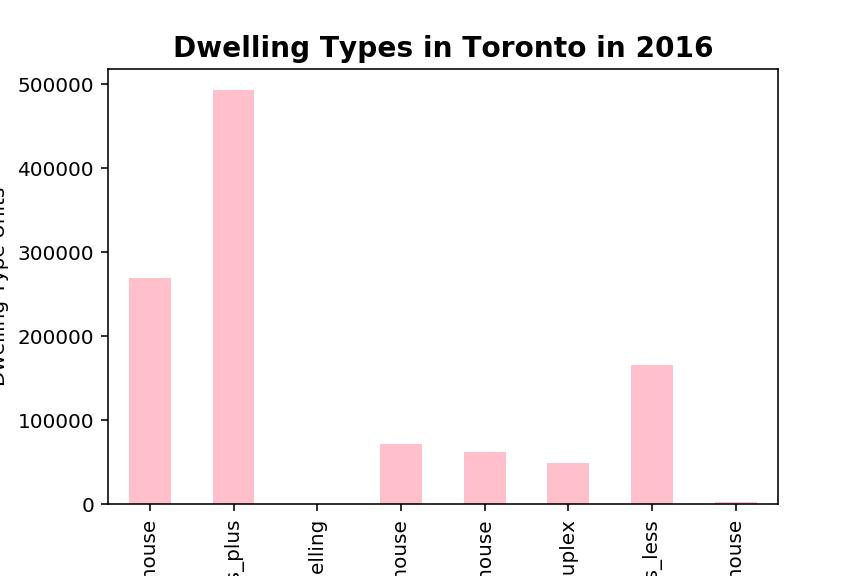
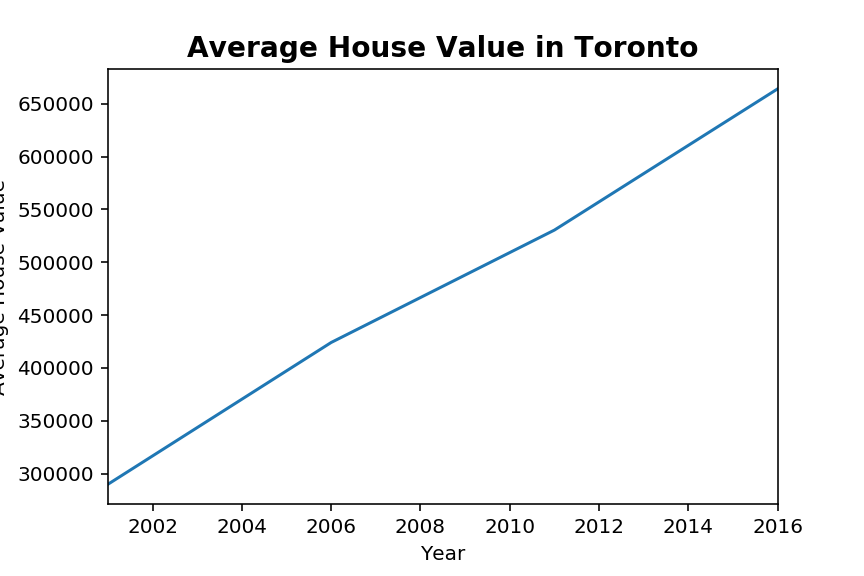
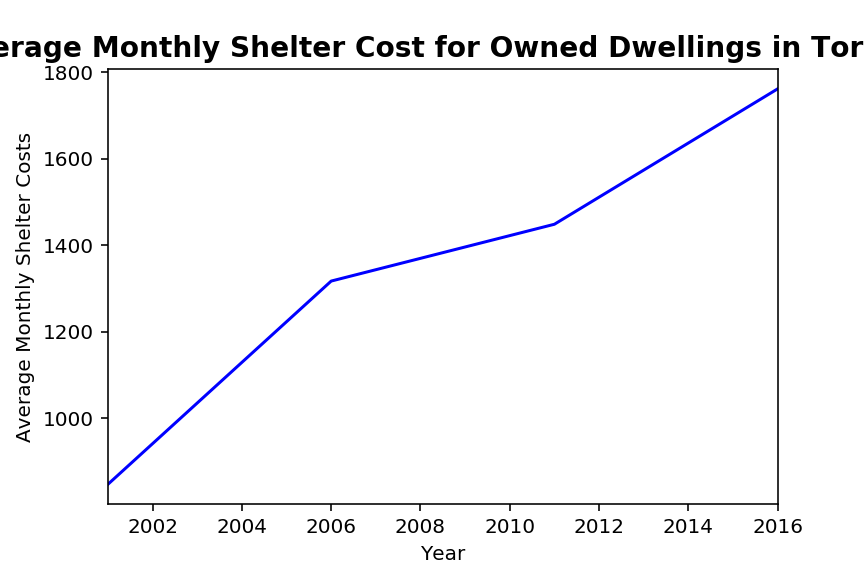
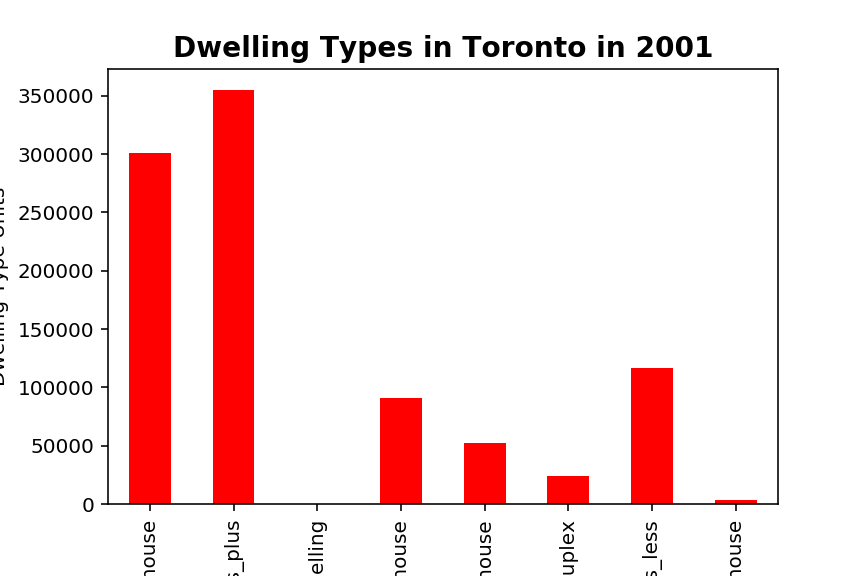
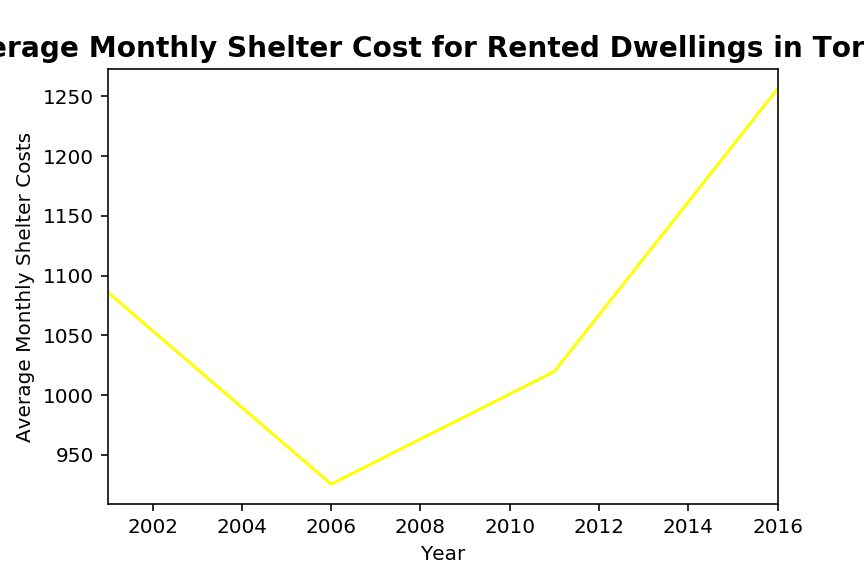
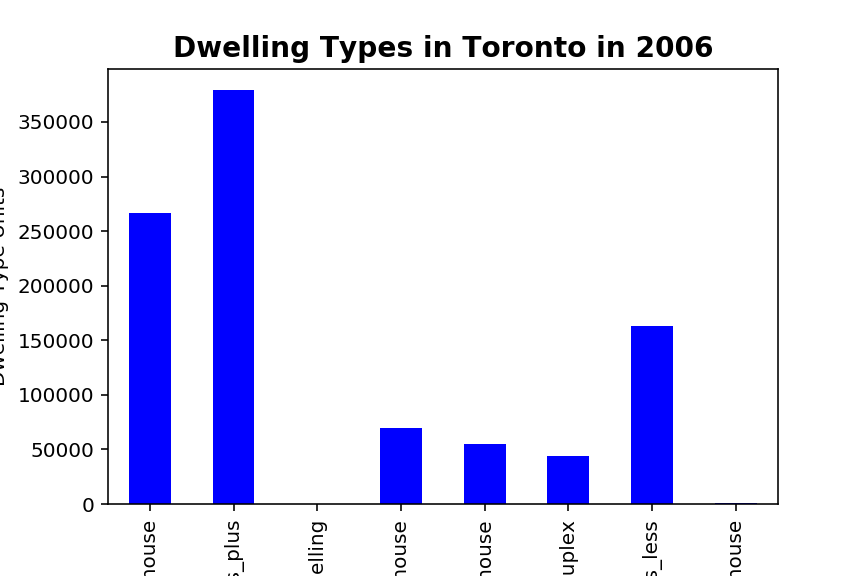
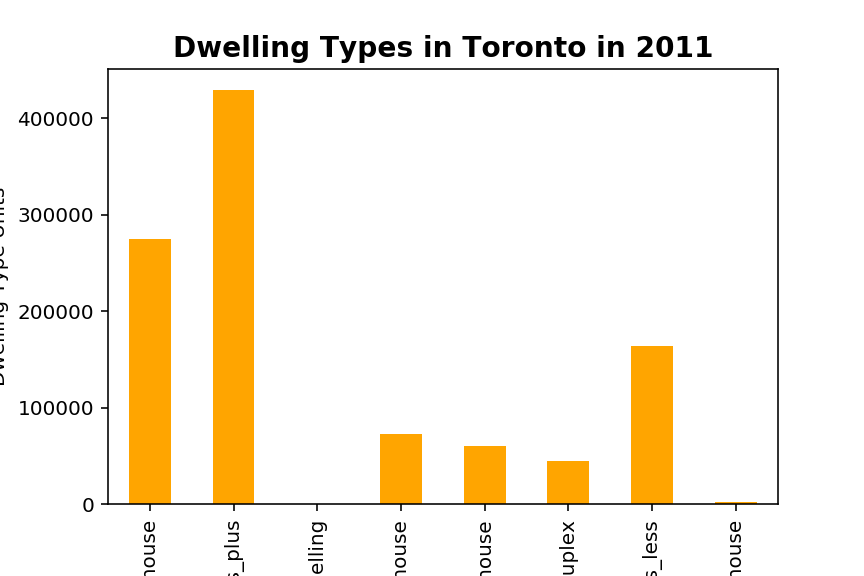

In [46]:
dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [87]:
# neighbourhood_map().show()

In [75]:
# create_bar_chart(data, title, xlabel, ylabel, color)

# # Bar chart for 2001
# create_bar_chart(df_dwelling_units.loc[2001], "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red")

# # Bar chart for 2006
# create_bar_chart(df_dwelling_units.loc[2006], "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue")

# # Bar chart for 2011
# create_bar_chart(df_dwelling_units.loc[2011], "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "orange")

# # Bar chart for 2016
# create_bar_chart(df_dwelling_units.loc[2016], "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta")

In [11]:
# create_line_chart(data, title, xlabel, ylabel, color)

# # Line chart for owned dwellings
# create_line_chart(df_avg_costs["shelter_costs_owned"], "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue")

# # Line chart for rented dwellings
# create_line_chart(df_avg_costs["shelter_costs_rented"], "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "orange")

In [66]:
# average_house_value()

In [84]:
# average_value_by_neighbourhood()

In [79]:
# number_dwelling_types()

In [70]:
# average_house_value_snapshot()

In [72]:
# top_most_expensive_neighbourhoods()

In [74]:
# sunburts_cost_analysis()